In [2]:
import torch
import torch.nn.functional as F
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

Sample Graph data 

In [3]:
# Define the Graph data structure
edge_index = torch.tensor([[0, 1, 0],  # From nodes (A -> B, B -> C, A -> C)
                                [1, 2, 2]],     # To nodes
                          dtype=torch.long)
node_labels = ["A", "B", "C"]

In [4]:
graph_data = Data(edge_index=edge_index)

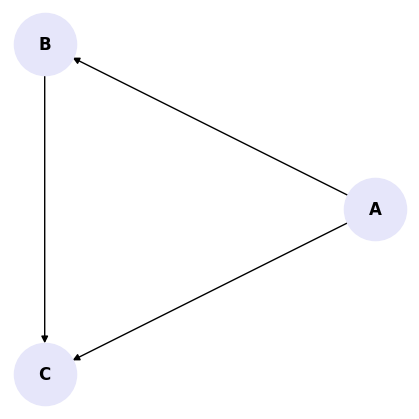

In [5]:
# Convert to NetworkX for visualization
G = nx.DiGraph()
G.add_edges_from(edge_index.t().tolist())

plt.figure(figsize=(4, 4))
pos = nx.circular_layout(G)  # Automatically adjust nodes location
nx.draw(G, pos,
        with_labels=True, labels={i: node_labels[i] for i in range(len(node_labels))},
        node_color='lavender',
        edge_color='black',
        node_size=2000,
        font_size=12, font_weight='bold', arrows=True)
plt.show()

Simple GCN with dummy data (Node classification)

In [6]:
# Dummy dataset
num_nodes = 5
num_features = 3
num_classes = 2

x = torch.randn(num_nodes, num_features) # random node features
edge_index = torch.tensor([[0, 1, 1, 2, 3, 4], [1, 2, 3, 4, 0, 1]], dtype=torch.long) # random edges 
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long) # random labels

data = Data(x=x, edge_index=edge_index, y=y)

In [7]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [9]:
model = SimpleGNN(num_features=num_features, hidden_channels=4,num_classes=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.1392323970794678
Epoch 10, Loss: 0.776576578617096
Epoch 20, Loss: 0.6814289093017578
Epoch 30, Loss: 0.6578067541122437
Epoch 40, Loss: 0.627052903175354
Epoch 50, Loss: 0.6094847321510315
Epoch 60, Loss: 0.5909316539764404
Epoch 70, Loss: 0.5759187340736389
Epoch 80, Loss: 0.5554971098899841
Epoch 90, Loss: 0.5312680006027222


In [10]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
print(f'Predictions: {pred}')
print(f'Ground Truth: {data.y}')

Predictions: tensor([0, 1, 0, 0, 0])
Ground Truth: tensor([0, 1, 0, 1, 0])
